In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [194]:
SCALER = 'MINMAX'
LAST_N = -20

In [195]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [196]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5320,2024-04-22,5010.600098,1373.930054,2332.199951,2629.439941,2623.020020
5321,2024-04-23,5070.549805,1378.839966,2327.699951,2623.020020,2675.750000
5322,2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000,2628.620117
5323,2024-04-25,5048.419922,1376.969971,2345.600098,2628.620117,2654.820068
5324,2024-04-26,5048.419922,1376.969971,2345.600098,2654.820068,2654.820068


In [197]:
# df = df.drop('Date', axis=1)
df_1 = df.iloc[:LAST_N, :].copy()
df_1 = df_1.drop('Date', axis=1)
print(df_1.tail())
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold        kospi  kospi_shift
5300  5218.189941  1343.599976  2174.800049  2737.570068  2757.090088
5301  5203.580078  1339.130005  2175.600098  2757.090088  2755.110107
5302  5248.490234  1343.060059  2190.600098  2755.110107  2745.820068
5303  5254.350098  1349.800049  2217.399902  2745.820068  2746.629883
5304  5254.350098  1349.800049  2217.399902  2746.629883  2747.860107
['S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [198]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.176439e+03,1128.592628,1243.401047,1936.004939
var,1.273283e+06,12442.610459,216811.232142,295052.537738
max,5.254350e+03,1571.400024,2217.399902,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027


In [199]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi
2767,0.283170,0.181271,0.515033,0.495398
1420,0.050834,0.509581,0.292087,0.269015
4672,0.846506,0.409875,0.772333,0.891817
981,0.177571,0.073943,0.166992,0.446759
3128,0.308518,0.374416,0.377564,0.507070


In [200]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
model_list = [xgb, lgbm, rf]

In [201]:
# XGB
param_xgb = {"max_depth": [10, 30, 50],
              "min_child_weight" : [1, 3, 6, 10],
              "n_estimators": [100, 200, 300, 500, 1000]
              }    
# LGB                        
param_lgbm = {"learning_rate" : [0.01, 0.1, 0.2, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 1000],
             "n_estimators" : [100, 200, 300, 500, 1000],
             "learning_rate" : [0.01, 0.1, 0.2, 0.5]
              }
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
params_list = [param_xgb, param_lgbm, params_rf]

In [202]:
# grid_result = pd.DataFrame(columns=['xgb', 'lgbm', 'rf'], index=['params', 'best'])

# for i in range(len(model_list)):
#     grid_model = GridSearchCV(estimator=model_list[i], param_grid=params_list[i], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
#     grid_model.fit(train_x, train_y)
#     # grid_result.iloc[0, i] = grid_model.best_params_
#     # grid_result.iloc[1, i] = grid_model.best_score_
#     print(grid_model.best_params_)
#     print(grid_model.best_score_)

# grid_result

In [203]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=99)
rf.fit(train_data, train_y)
pred = rf.predict(test_data)

result = mean_squared_error(test_y, pred)
result

540.8284259782209

kospi       0.999630
S&P         0.000139
currency    0.000116
gold        0.000115
dtype: float64


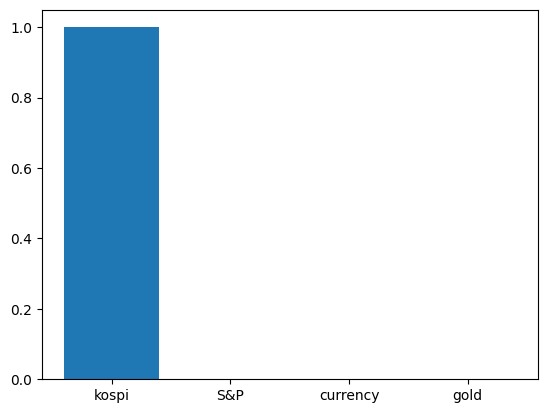

In [204]:
rf_importances = pd.Series(rf.feature_importances_, index = train_x.columns)
plt.bar(rf_importances.sort_values(ascending=False).index, rf_importances.sort_values(ascending=False))
print(rf_importances.sort_values(ascending=False))
plt.show()

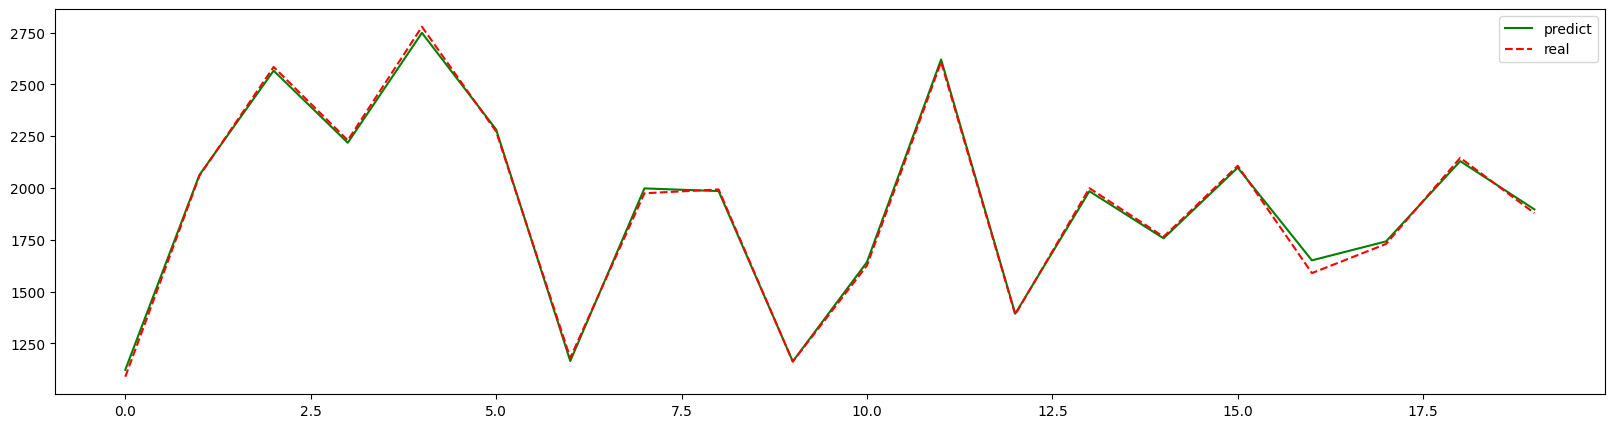

In [205]:
plt.figure(figsize=(20, 5))
plt.plot(pred[-50:-30], 'g-', label='predict')
plt.plot(test_y[-50:-30].values, 'r--', label='real')
plt.legend()
plt.show()

In [206]:
# recent untested data prediction
for i in col_names[:-1]:
    input = df.iloc[LAST_N:, 1:].drop('kospi_shift', axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
pred_last = rf.predict(input)
df_pred = pd.DataFrame(columns=['y', 'pred', 'diff'])
df_pred['pred'] = pred_last
df_pred['y'] = df.iloc[LAST_N:, -1:].values
df_pred['diff'] = df_pred['y'] - df_pred['pred']
df_pred

,y,pred,diff
0,2753.159912,2752.514185,0.645728
1,2706.969971,2753.757021,-46.787050
2,2742.000000,2712.769184,29.230816
3,2714.209961,2745.394657,-31.184696
4,2717.649902,2713.751134,3.898768
5,2705.159912,2715.012833,-9.852920
6,2706.959961,2713.087658,-6.127697
7,2706.959961,2713.087658,-6.127697
8,2681.820068,2712.769184,-30.949116
9,2670.429932,2699.165290,-28.735358


In [207]:
df.iloc[LAST_N:, 0:1].values.reshape(-1)

array(['2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04',
       '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10',
       '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16',
       '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
       '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26'],
      dtype=object)

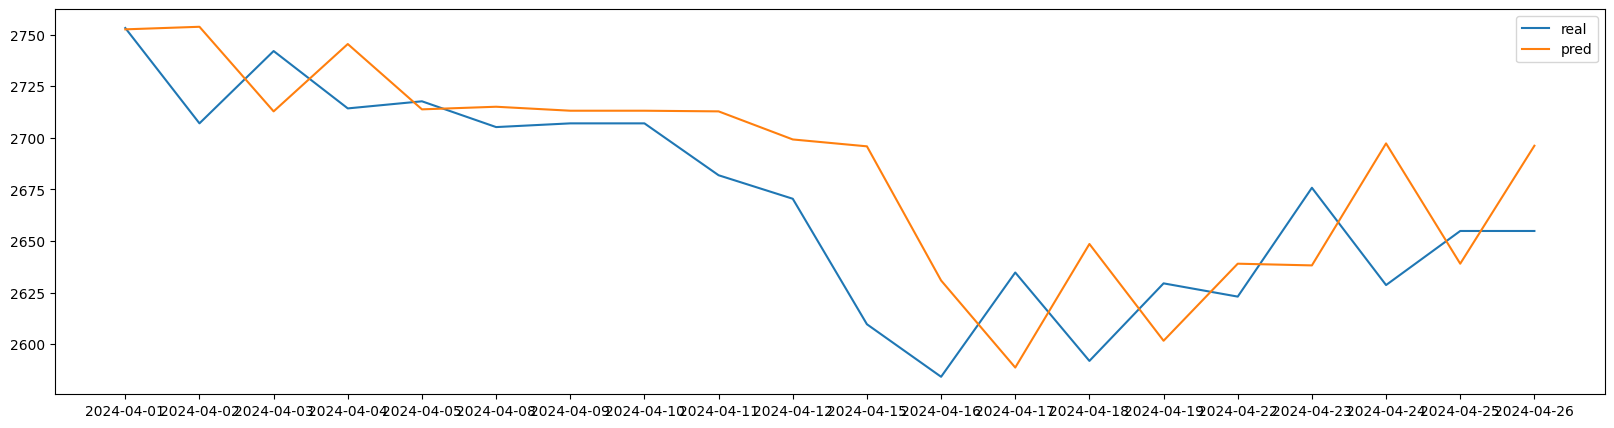

In [208]:
# recent untested data prediction
plt.figure(figsize=(20, 5))
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['y'], label='real')
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['pred'], label='pred')
plt.legend()
plt.show()

In [215]:
df_test_result = pd.merge(test_y, df['Date'], left_index=True, right_index=True, how='left')
df_test_result['pred'] = pred
df_test_result = df_test_result[['Date', 'pred', 'kospi_shift']]
df_test_result['diff'] = df_test_result['pred'] - df_test_result['kospi_shift']
df_test_result = df_test_result.sort_index(ascending=True)
df_test_result

,Date,pred,kospi_shift,diff
22,2003-12-31,815.251612,821.260010,-6.008398
30,2004-01-12,852.430759,848.429993,4.000767
38,2004-01-22,866.892752,869.039978,-2.147226
41,2004-01-27,867.129904,859.590027,7.539877
48,2004-02-05,843.789255,850.229980,-6.440725
...,...,...,...,...
5249,2024-01-12,2524.716244,2525.989990,-1.273746
5250,2024-01-15,2524.999924,2497.590088,27.409836
5260,2024-01-29,2507.017148,2498.810059,8.207089
5278,2024-02-22,2661.960750,2667.699951,-5.739201


In [224]:
(np.square(df_test_result['diff']).sum()/len(df_test_result))**0.5

23.255718135078542

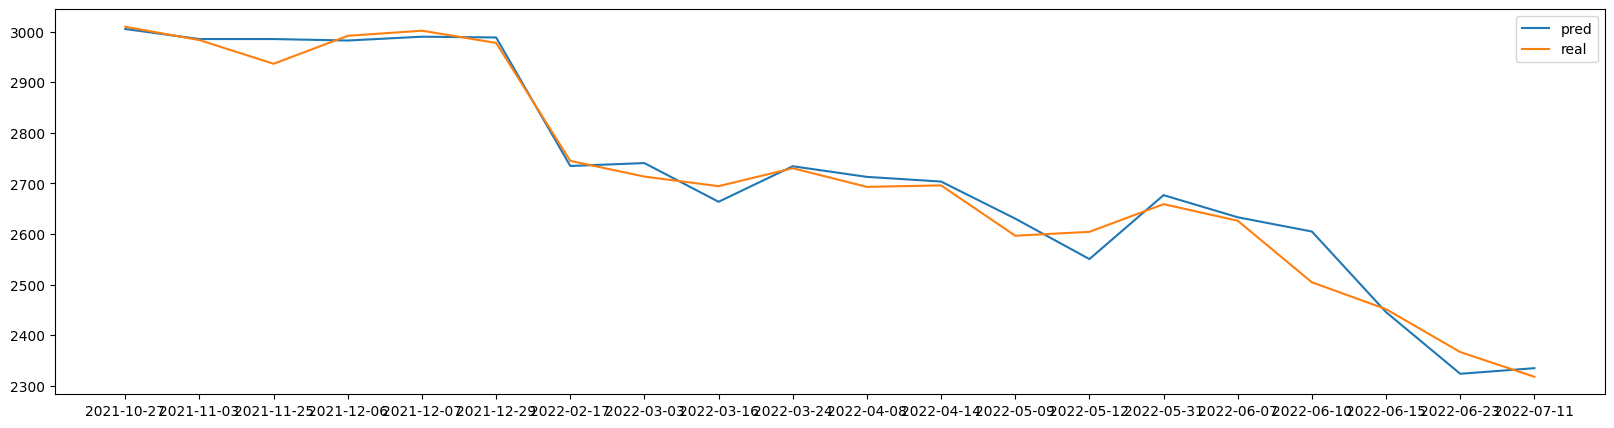

In [220]:
start = -60
end = -40
plt.figure(figsize=(20, 5))
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 1:2].values, label='pred')
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 2:3].values, label='real')
plt.legend()
plt.show()